In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import numpy as np
from tqdm import tqdm
from ste import STE

# Time-series dataset

In [2]:
# Define the country name.
COUNTRY = "Yemen"

In [3]:
PATH_TO_DATA_FOLDER = "../Dataset time-series/data/" + COUNTRY + "/"

In [4]:
# Load the time-series dataset.
df = pd.read_csv(PATH_TO_DATA_FOLDER + "%s-day.csv" % COUNTRY, header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq

In [5]:
INDICATORS_TO_CONSIDER = ["FCS", "1 Month Anomaly (%) Rainfall", "Cereals and tubers", "Exchange rate", "Fatality", "NDVI Anomaly", "rCSI", "Rainfall (mm)"]

In [6]:
# Consider only some indicators for the analysis with symbolic transfer entropy.
df = pd.concat([df.loc[:, (slice(None), feature)] for feature in INDICATORS_TO_CONSIDER], axis = 1).sort_index(axis = 1)

In [7]:
# Rename some indicators.
df.rename({"1 Month Anomaly (%) Rainfall": "Rainfall Anomaly", "Fatality": "Fatalities", "Cereals and tubers": "Price cereals and tubers"}, axis = 1, level = 1, inplace = True)

In [8]:
PROVINCES = df.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [9]:
PREDICTORS = df.columns.get_level_values(1).unique()
PREDICTORS

Index(['Rainfall Anomaly', 'Price cereals and tubers', 'Exchange rate', 'FCS',
       'Fatalities', 'NDVI Anomaly', 'Rainfall (mm)', 'rCSI'],
      dtype='object', name='Indicator')

In [10]:
# Assign a color to each indicator.
cols = plt.get_cmap("tab10")

colors = dict()
for i,indicator in enumerate(reversed(PREDICTORS)):
    colors[indicator] = cols(i)

# Importance of the indicators

In [11]:
df_feature_importance = df.drop("FCS", axis = 1, level = 1)

In [12]:
rows_ste = list()
rows_ste_rank = list()

def feature_importance(group):
    adminstrata = group.name
    rows = dict()
    for indicator in df_feature_importance.columns.get_level_values(1).unique():
        result = STE.calc_ste(group[adminstrata][indicator], df[adminstrata]["FCS"], m = 3, kx = 1, ky = 1, h = 1)
        rows[indicator] = result
    row = pd.Series(rows)
    row.name = adminstrata + " - FCS"
    rows_ste.append(row)
    rows_ste_rank.append(row.rank(method = "max", ascending = False))

tqdm.pandas()
df_feature_importance.groupby(level = 0, axis = 1).progress_apply(feature_importance);
T_fcs = pd.concat(rows_ste, axis = 1).transpose()
T_fcs_rank = pd.concat(rows_ste_rank, axis = 1).transpose()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.05it/s]


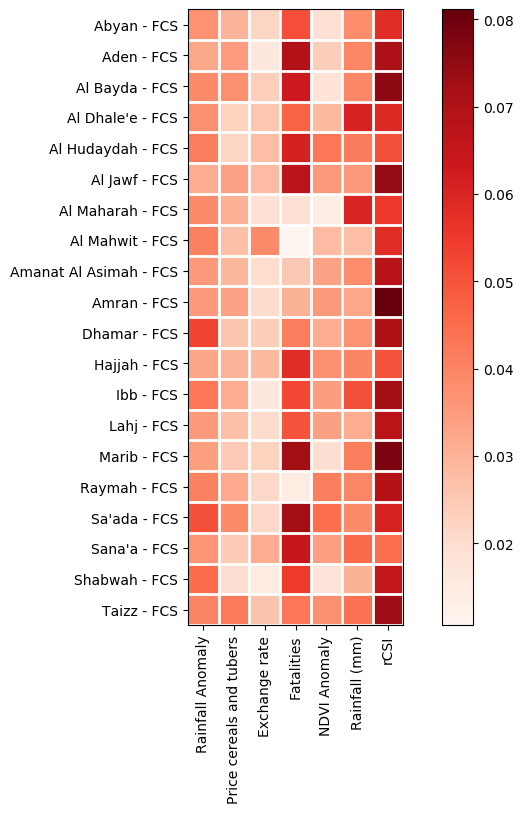

In [13]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (10, 8))
    im = ax.imshow(T_fcs.astype(float), cmap = "Reds")
    cbar = fig.colorbar(im, ax = ax)
    #clb = plt.colorbar()
    #cbar.set_label("STE", rotation = 270)

    ax.set_xticks(range(len(T_fcs.columns)))
    ax.set_yticks(range(len(T_fcs.index)))
    ax.set_xticklabels(T_fcs.columns, rotation = 90)
    ax.set_yticklabels(T_fcs.index)
    #ax.set_xlabel("Indicator")
    #ax.set_ylabel("AdminStrata")
    #ax.set_title("T - Influence different indicators for FCS")
    for i in range(T_fcs.shape[0]):
        ax.axhline(i + 0.5, color = "white", lw = 2)
    for i in range(T_fcs.shape[1]):
        ax.axvline(i + 0.5, color = "white", lw = 2)
        
    # Save the figure.
    fig.savefig("./images/Importance.png", bbox_inches = "tight", dpi = 300)

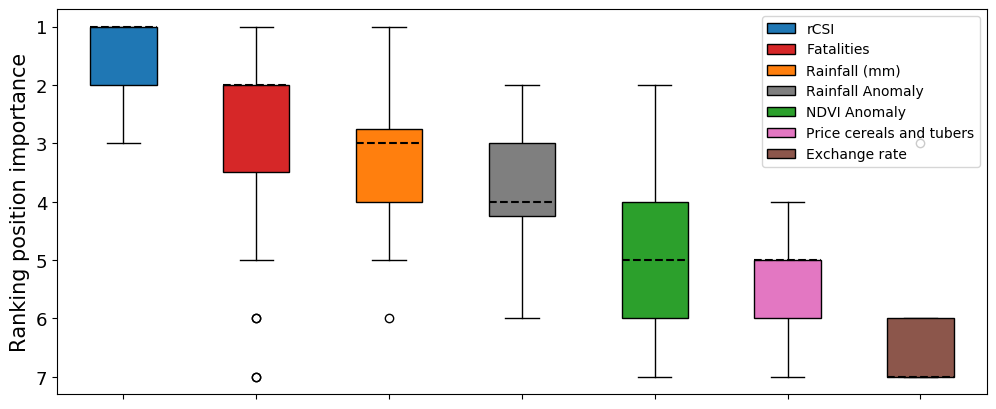

In [14]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (12, 5))
    T_fcs_rank = T_fcs_rank.astype(int)
    meds = T_fcs_rank.mean()
    meds.sort_values(ascending = True, inplace = True)
    T_fcs_rank_sort = T_fcs_rank[meds.index]
    #T_fcs_rank_sort = T_fcs_rank_sort[['rCSI', 'Fatalities', 'Rainfall (mm)', 'Rainfall Anomaly', 'NDVI Anomaly', 'Price cereals and tubers', 'Exchange rate']]
    #cm = plt.cm.get_cmap("tab20")
    #colors = [cm(val/len(T_fcs_rank_sort.columns)) for val in range(len(T_fcs_rank_sort.columns))]
    bplot = ax.boxplot(T_fcs_rank_sort.T, patch_artist = True, medianprops = {"linestyle": "--", "linewidth": 1.5, "color": "black"}) 
    # Fill with colors.
    legends = list()
    for patch, indicator in zip(bplot["boxes"], T_fcs_rank_sort.columns):
        patch.set_facecolor(colors[indicator])
        patch.set_label(indicator)
        legends.append(patch)
    
    ax.invert_yaxis()
    #ax.set_xlabel("Indicator")
    ax.set_ylabel("Ranking position importance", fontsize = 15)
    ax.tick_params(labelsize = 13)
    ax.set_xticklabels([""]*len(T_fcs_rank_sort.columns), rotation = 0, fontsize = 15)  

    ax.legend(legends, T_fcs_rank_sort.columns, loc='upper right')
    
    # Save the figure.
    fig.savefig("./images/Ranking.png", bbox_inches = "tight", dpi = 300)

# Lag importance

In [15]:
# Compute the entropy rate of the endogenous indicators (FCS indicator)..
lags = 15
def history_length_Y(serie):
    adminstrata = serie.name[0]
    y = list()
    for k in range(lags):
        result = STE.entropy_rate(serie, m = 3, k = k+1, h = 1)
        y.append(result)  
    return y  

tqdm.pandas()
df_results_Y = df.xs("FCS", axis = 1, level = 1, drop_level = False).progress_apply(history_length_Y)
df_results_Y.index = df_results_Y.index  + 1
df_results_Y.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,Dhamar,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
1,1.441839,1.472724,1.485876,1.441661,1.416569,1.472792,1.473681,1.472655,1.439768,1.453558,1.486763,1.442429,1.442988,1.453810,1.475240,1.453813,1.453687,1.472296,1.475541,1.477265
2,1.419034,1.435327,1.465003,1.432016,1.385660,1.440749,1.449183,1.453511,1.420045,1.414003,1.469268,1.424757,1.427566,1.433032,1.442643,1.429401,1.431523,1.446329,1.445908,1.438662
3,1.324911,1.359299,1.375386,1.365739,1.311403,1.358428,1.376465,1.386042,1.333211,1.330820,1.406874,1.319817,1.330998,1.365560,1.361382,1.322076,1.354915,1.356592,1.382866,1.343727
4,1.133354,1.168623,1.183902,1.137651,1.139417,1.139915,1.127696,1.167684,1.125207,1.118704,1.179111,1.103693,1.148834,1.154769,1.158333,1.102370,1.146297,1.160160,1.176659,1.127171
5,0.818754,0.793303,0.773321,0.808688,0.886359,0.769050,0.802421,0.811355,0.770425,0.793215,0.770734,0.809963,0.823792,0.820213,0.778900,0.793350,0.805737,0.798792,0.785167,0.784764


In [16]:
#df_results_Y = df_results_Y.diff().dropna()

In [17]:
def plot_quantiles(df, title = None, xaxis = None, yaxis = None, label = None):
    with plt.style.context("default"):
        # Define the subplot figure.
        fig, axs = plt.subplots(figsize = (15, 7))
        value_statistic = df.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = label, ax = axs, ms = 12, c = colors["FCS"])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors["FCS"], alpha = 0.3)
        # Set attributes of the plot.
        axs.set_title(title)
        axs.legend(loc = "best", prop = {"size": 15})
        axs.set_xlabel(xaxis, fontsize = 18)
        axs.set_ylabel(yaxis, fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(1, 16))
    return fig, axs

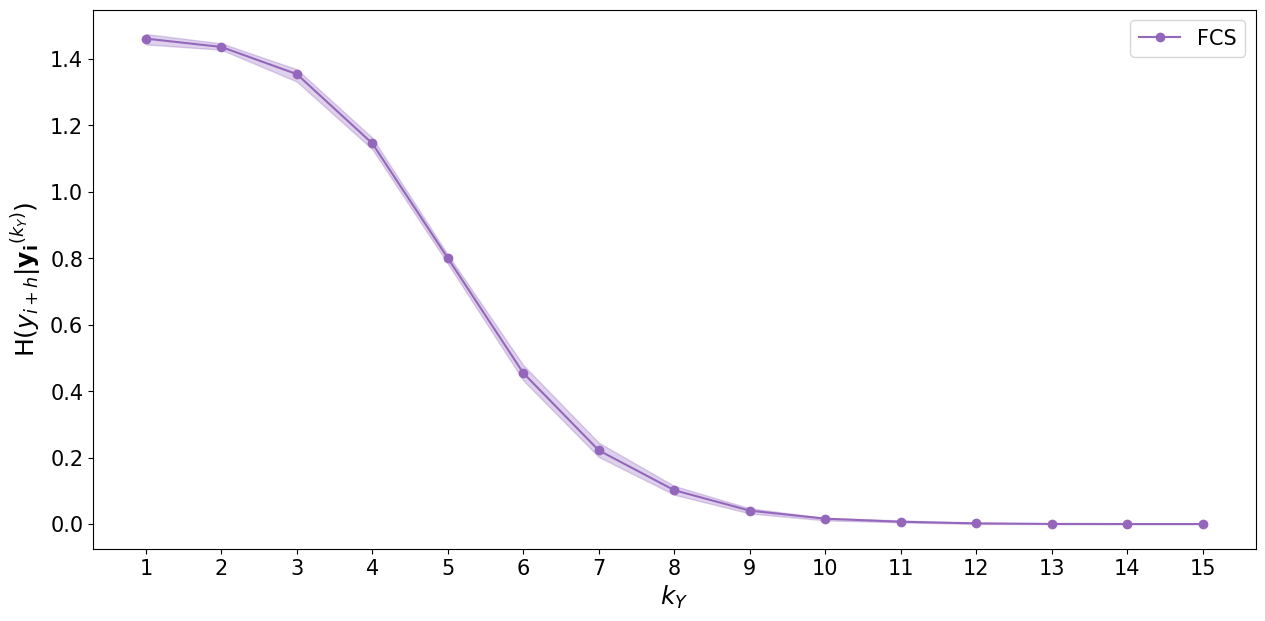

In [18]:
fig, axs = plot_quantiles(df_results_Y, xaxis = "$k_{Y}$", yaxis = "H($y_{i+h}|\mathbf{y_{i}}^{(k_Y)}$)", label = "FCS")

In [19]:
fig.savefig("./images/entropy_rate.png", bbox_inches = "tight", dpi = 300)

In [20]:
# Select only the exogenous indicators.
df_no_fcs = df.drop(columns = ["FCS"], axis = 1, level = 1)
df_no_fcs.head()

AdminStrata            Abyan                                         \
Indicator   Rainfall Anomaly Price cereals and tubers Exchange rate   
Datetime                                                              
2018-08-22         90.454758                 0.184064      0.207215   
2018-08-23         89.927580                 0.185383      0.210332   
2018-08-24         89.436780                 0.186702      0.213449   
2018-08-25         88.982357                 0.188021      0.216565   
2018-08-26         88.564312                 0.189340      0.219682   

AdminStrata                                                              Aden  \
Indicator   Fatalities NDVI Anomaly Rainfall (mm)       rCSI Rainfall Anomaly   
Datetime                                                                        
2018-08-22        10.0    98.450151       12.9544  37.421880       103.239156   
2018-08-23        10.0    98.353086       13.0949  37.346207       102.928818   
2018-08-24        10.0    98.254291       13.2354  37.999408       102.652003   
2018-08-25        10.0    98.153766       13.3759  36.068234       102.408712   
2018-08-26        10.0    98.051510       13.5164  38.218464       102.198944   

AdminStrata                                         ...      Shabwah  \
Indicator   Price cereals and tubers Exchange rate  ... NDVI Anomaly   
Datetime                                            ...                
2018-08-22                  0.145709      0.196182  ...    99.411750   
2018-08-23                  0.148744      0.199236  ...    99.381895   
2018-08-24                  0.151779      0.202291  ...    99.351971   
2018-08-25                  0.154814      0.205345  ...    99.321979   
2018-08-26                  0.157849      0.208400  ...    99.291919   

AdminStrata                                     Taizz  \
Indicator   Rainfall (mm)       rCSI Rainfall Anomaly   
Datetime                                                
2018-08-22        12.5713  34.302200        93.865658   
2018-08-23        12.8403  36.742499        94.296436   
2018-08-24        13.1093  35.857748        94.778817   
2018-08-25        13.3783  34.658434        95.312802   
2018-08-26        13.6473  35.913080        95.898390   

AdminStrata                                                                 \
Indicator   Price cereals and tubers Exchange rate Fatalities NDVI Anomaly   
Datetime                                                                     
2018-08-22                  0.200933      0.207371      171.0   104.340193   
2018-08-23                  0.201173      0.210846      147.0   104.184601   
2018-08-24                  0.201412      0.214321      145.0   104.021750   
2018-08-25                  0.201651      0.217796      156.0   103.851638   
2018-08-26                  0.201891      0.221272      164.0   103.674267   

AdminStrata                           
Indicator   Rainfall (mm)       rCSI  
Datetime                              
2018-08-22        41.6606  50.919038  
2018-08-23        42.6437  50.415852  
2018-08-24        43.6268  49.391298  
2018-08-25        44.6099  50.302392  
2018-08-26        45.5930  50.293046  

[5 rows x 140 columns]

In [21]:
lags = 15

In [22]:
def history_length_X(serie):
    adminstrata = serie.name[0]
    indicator = serie.name[1]
    y = list()
    for k in range(lags):
        result = STE.calc_ste(serie, df[adminstrata]["FCS"], m = 3, kx = k+1, ky = 1, h = 1)
        y.append(result)        
    return y  

tqdm.pandas()
df_results_X = df_no_fcs.progress_apply(history_length_X)
df_results_X.head()

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [01:22<00:00,  1.70it/s]


AdminStrata            Abyan                                         \
Indicator   Rainfall Anomaly Price cereals and tubers Exchange rate   
0                   0.036983                 0.029513      0.022166   
1                   0.063843                 0.043434      0.033856   
2                   0.092009                 0.057987      0.050759   
3                   0.116878                 0.074486      0.060372   
4                   0.145934                 0.100275      0.072311   

AdminStrata                                                             Aden  \
Indicator   Fatalities NDVI Anomaly Rainfall (mm)      rCSI Rainfall Anomaly   
0             0.050897     0.018642      0.038054  0.058041         0.032343   
1             0.119110     0.031845      0.086624  0.217705         0.064134   
2             0.242464     0.044301      0.121915  0.502128         0.092600   
3             0.322452     0.054843      0.169276  0.845614         0.115747   
4             0.390930     0.064362      0.207496  1.147523         0.140745   

AdminStrata                                         ...      Shabwah  \
Indicator   Price cereals and tubers Exchange rate  ... NDVI Anomaly   
0                           0.034943      0.016432  ...     0.017741   
1                           0.053211      0.032626  ...     0.032281   
2                           0.065447      0.050408  ...     0.048943   
3                           0.085158      0.064448  ...     0.065761   
4                           0.111468      0.082776  ...     0.080298   

AdminStrata                                    Taizz                           \
Indicator   Rainfall (mm)      rCSI Rainfall Anomaly Price cereals and tubers   
0                0.030096  0.065276         0.039987                 0.042057   
1                0.054756  0.222724         0.075950                 0.068369   
2                0.084957  0.534780         0.108404                 0.088171   
3                0.127672  0.903977         0.146060                 0.115308   
4                0.156674  1.162289         0.180937                 0.137304   

AdminStrata                                                                
Indicator   Exchange rate Fatalities NDVI Anomaly Rainfall (mm)      rCSI  
0                0.026136   0.043081     0.037641      0.043960  0.072916  
1                0.043105   0.203795     0.062758      0.079561  0.236395  
2                0.062620   0.451518     0.086232      0.115774  0.535829  
3                0.077678   0.755379     0.114081      0.154791  0.901966  
4                0.090061   1.000320     0.133113      0.198761  1.166463  

[5 rows x 140 columns]

In [23]:
df_results_X = df_results_X.diff().dropna()

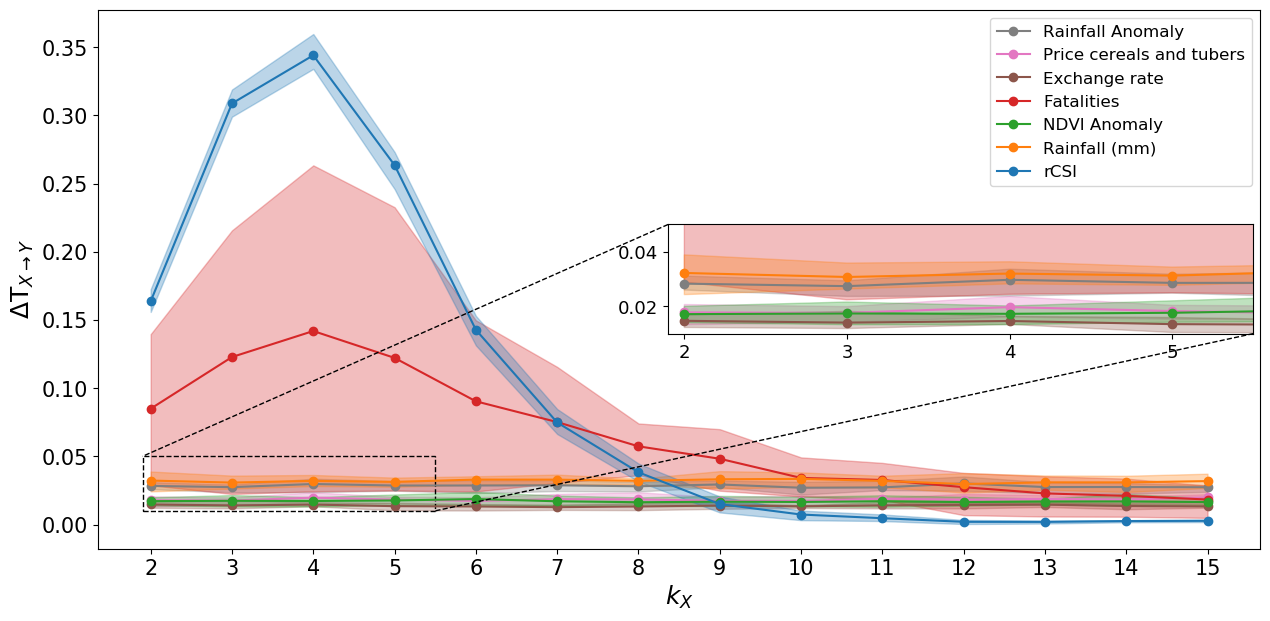

In [24]:
with plt.style.context("default"):
    # Define the subplot figure.
    fig, axs = plt.subplots(figsize = (15, 7))
    axins = zoomed_inset_axes(axs, 2., loc = "right")
    for i,indicator in enumerate(df_results_X.columns.get_level_values(1).unique()):
        subdf = df_results_X.xs(indicator, axis = 1, level = 1, drop_level = False)
        subdf.index = subdf.index + 1
        value_statistic = subdf.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axs, ms = 12, c = colors[indicator])
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axins, ms = 12, c = colors[indicator])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                           y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.set_xticks(np.arange(1, 6))
        axins.tick_params(labelsize = 13)
        # Set attributes of the plot.
        axs.legend(loc = "best", prop = {"size": 12})
        axs.set_xlabel("$k_{X}$", fontsize = 18)
        axs.set_ylabel(r'$\Delta$T$_{X \rightarrow Y}$', fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(2, 16))

    axins.set_xlim(1.9, 5.5)
    axins.set_ylim(0.01, 0.05)
    mark_inset(axs, axins, loc1 = 2, loc2 = 4, fc = "none", ec = "black", linestyle  = "--")
    # Save the figure.
    fig.savefig("./images/Lags.png", bbox_inches = "tight", dpi = 300)